# Assignment 3: Stereo vision 

In this assignment, you will implement a stereo vision algorithm, with and without using dynamic programming. The sub-assignments will be described below.

First, we import packages and allow for potting of figures (disabled when using autograder). Do not touch this cell.

In [1]:
import cv2
import numpy as np
import scipy.ndimage as sp
from matplotlib import pyplot as plt
import time
from skimage.metrics import structural_similarity as compare_ssim

testing = False
if __name__ == '__main__':    
    testing = True

Import the left and right image.

In [2]:
image_left = cv2.imread('left1.png', 0)
image_right =  cv2.imread('right1.png', 0)

Set the global parameters. You will need to tune these parameters to get a good solution.

In [3]:
filter_coeffs = 1 # Filter coefficient for the LoG filter
blocksize_log = 9 # Block size of the LoG filter
blocksize_dsi = 21 # Block size of the sum filter in the DSI
winner_margin = 0.95 # Winner margin
trans_cost_power = 2.5 # Transition cost power for dynamic programming
trans_cost_multiplier = 2000 # Transition cost multiplier for dynamic programming


# Exercise 1a: Edge filter
Apply an edge filter to the images, by using a Laplacian over Gaussian (LoG) filter (as in the previous assignments).

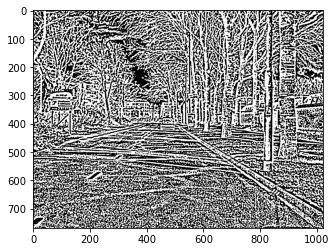

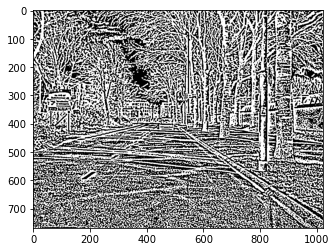

In [4]:
def log_filter(image_left, image_right, blocksize_log, filter_coeffs):
    # Add your code here
    blocksize = blocksize_log
    sigma = filter_coeffs
    image_left_edge = cv2.Laplacian(cv2.GaussianBlur(image_left,(blocksize,blocksize),sigma),cv2.CV_8U,ksize=blocksize)
    image_right_edge =  cv2.Laplacian(cv2.GaussianBlur(image_right,(blocksize,blocksize),sigma),cv2.CV_8U,ksize=blocksize)
    return [image_left_edge.astype(dtype=np.uint8), 
            image_right_edge.astype(dtype=np.uint8)] #outputs should be in np.uint8 format

if testing: #plotting
    [image_left_edge, image_right_edge] = log_filter(image_left,image_right, blocksize_log, filter_coeffs)
    p = plt.figure(1)
#     print(image_left_edge[:,:3])
    plt.imshow(image_left_edge, cmap='gray', vmin=0, vmax=255)
    p2 = plt.figure(2)
    plt.imshow(image_right_edge, cmap='gray', vmin=0, vmax=255)


# Exercise 1b: Calculate DSI matrix
Make a function that calculates the DSI matrix for the given left and right images. The maximum disparity (`d_max`) is 16.

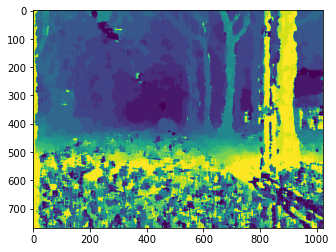

In [5]:
def calc_disparity(image_left_edge, image_right_edge, blocksize_dsi):
    # Add your code here
    d_max=16
    img_height = np.shape(image_left_edge)[0]
    img_width = np.shape(image_left_edge)[1]
    image_disparity = np.ones((img_height,img_width,d_max),dtype=np.uint16)
    #block sum filter kernel
    weights = np.ones((blocksize_dsi,blocksize_dsi,1),dtype = int)
    
    for i in range(d_max):
        image_disparity[:,i:,i] = np.abs(image_left_edge[:,i:]-image_right_edge[:,:img_width-i],dtype=np.uint16)
#         for x in range(img_width-i-1):
#             image_disparity[:,x,i] = np.abs(image_left_edge[:,x+i]-image_right_edge[:,x])
    
    image_disparity_sum = sp.correlate(image_disparity,weights,mode='constant').astype(dtype=np.uint16)
    image_disparity_sum = np.abs(image_disparity_sum,dtype=np.uint16)#[768, 1024, 16]
    image_disparity_sorted = np.sort(image_disparity_sum,axis=2)
#     print('sum')
#     print(image_disparity_sum[:,:,0])
    image_disparity_sorted_index = np.argsort(image_disparity_sum,axis=2)
    return [image_disparity_sorted.astype(dtype=np.uint16), 
            image_disparity_sum.astype(dtype=np.uint16), 
            image_disparity_sorted_index.astype(dtype=np.uint16)] # outputs should be in np.uint16 format

if testing: # plotting
#     answer     
    b11=np.load('disp_sorted.npy')
    b12=np.load('disp_sum.npy')
#     print('b12')
#     print(b12[:,:,0])
    b13=np.load('disp_argsort.npy')
#     print(np.shape(b11)[0],sum(sum(sum(b12))),type(b13))
    [image_disparity_sorted, image_disparity_sum,  image_disparity_sorted_index] = calc_disparity(image_left_edge, image_right_edge, blocksize_dsi)
#     print(compare_ssim(b12,image_disparity_sum))
#     print(compare_ssim(b11,image_disparity_sorted))
#     print(compare_ssim(b13,image_disparity_sorted_index))
    p = plt.figure(3)
    plt.imshow(image_disparity_sorted_index[:,:,0], vmin=0, vmax=15)

# Exercise 1c: Winner margin and median filter
Apply winner margin to improve the result from the previous section. In other words, remove the disparities for pixels for which the winner margin does not hold. Subsequently, apply a median filter.

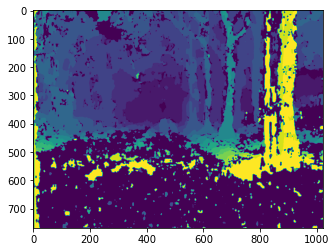

In [6]:
def calc_winner_margin(image_disparity_sorted, image_disparity_sorted_index, winner_margin):
    # Add your code here
    # np.seterr(divide='ignore',invalid='ignore')
    [rows,cols,d_max] = np.shape(image_disparity_sorted)
    margin = np.zeros((rows,cols),dtype=np.float64)
    for i in range(rows):
        for j in range(cols):
            if image_disparity_sorted[i,j,1]!=0:
                margin[i,j] = image_disparity_sorted[i,j,0]/image_disparity_sorted[i,j,1]
    for i in range(rows):
        for j in range(cols):
            if margin[i,j] >= winner_margin:
                image_disparity_sorted_index[i,j,:] = 0
    image_disparity_mean = sp.median_filter(image_disparity_sorted_index[:,:,0],size=6)
#     image_disparity_mean = image_disparity_sorted_index[:,:,0]
    return image_disparity_mean.astype(np.uint8) # output should be in np.uint8 format

if testing: #plotting
    image_disparity_mean = calc_winner_margin(image_disparity_sorted, image_disparity_sorted_index, winner_margin)
    p = plt.figure(4)
    plt.imshow(image_disparity_mean, vmin=0, vmax=15)
#     image_disparity_mean2 = calc_winner_margin(np.load("disp_sorted.npy"), np.load("disp_argsort.npy"), 0.95)    
#     b21 = np.load('winner_margin.npy')
#     print(compare_ssim(b21,image_disparity_mean2)) #0.8152267573738132

# Exercise 2: Dynamic programming
Implement the dynamic programming method to improve the disparity estimate. The inputs are:

* `image_disparity_sum`: the DSI block, from the previous exercise
* `trans_cost_power`: the 'power' of the transition cost
* `trans_cost_multiplier`: the multiplier for the transition cost, to get it in the same value range as the DSI cost

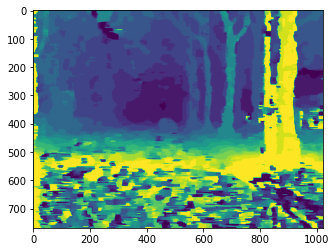

In [9]:
def dyn_prog(image_disparity_sum, trans_cost_power, trans_cost_multiplier):
    # Add your code here
    [rows,cols,d_max] = np.shape(image_disparity_sum) #data cost is the DIS slice in columns    
    trans_cost_2 = np.ones((d_max,d_max),dtype=np.uint16) #initialize transition cost matrix[16,16]
    image_disparity_dyn_prog = np.zeros((rows,cols),dtype=np.uint8) #initializing result
    for i in range(d_max): #build symmetric transition cost matrix
        for j in range(i,d_max):
            trans_cost_2[i,j] = trans_cost_multiplier*((j-i)**trans_cost_power)
            trans_cost_2[j,i] = trans_cost_2[i,j]
    trans_cost = np.expand_dims(trans_cost_2,0).repeat(rows,axis=0)
    min_path_cost = image_disparity_sum[:,:,:]
    min_path_cost = min_path_cost.astype(np.uint64) #[768,1024,16]
    #initialize min path index as zeros
    min_path_index = np.zeros((rows,cols,d_max),dtype=np.uint16) 
    #build min_path_cost and min_path_index
    #improve computation efficiency by saving the outer loop for rows
    for i in range(1,cols):
        for j in range(d_max):
            opt_pred = np.zeros((rows,d_max),dtype=np.uint64) #to find optimal predecessor for min_path_cost[i,j]
            opt_pred = min_path_cost[:,i-1,:]+trans_cost[:,:,j]
            min_path_cost[:,i,j] = min_path_cost[:,i,j]+np.min(opt_pred,axis=1)
            min_path_index[:,i,j] = np.argmin(opt_pred,axis=1)
    #back track the disparity
    for k in range(rows):
        image_disparity_dyn_prog[k,cols-1] = np.argmin(min_path_cost[k,cols-1,:])
        for i in range(cols-2,-1,-1):
            image_disparity_dyn_prog[k,i] = min_path_index[k,i,image_disparity_dyn_prog[k,i+1]]
    return image_disparity_dyn_prog.astype(dtype=np.uint8) # output should be in np.uint8 format

if testing: #plotting
    image_disparity_dyn_prog = dyn_prog(image_disparity_sum, trans_cost_power, trans_cost_multiplier)
    p = plt.figure(5)
    plt.imshow(image_disparity_dyn_prog, vmin=0, vmax=15)

# Exercise 3: Putting it all together
Implement the Stereo_vision function such that if called, it will return a) the disparity map without using dynamic programming, and b) the disparity map generated using dynamic programming.

Use the functions you created above.

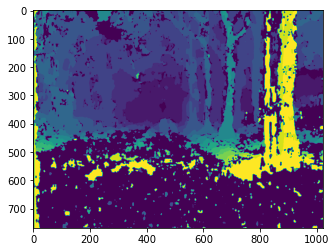

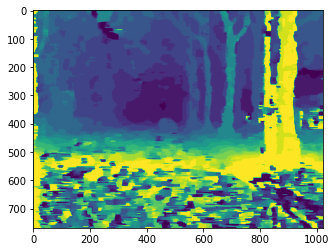

In [10]:
def stereo_vision(image):
    image_left = cv2.imread('left' + str(image) + '.png',0)
    image_right =  cv2.imread('right' + str(image) + '.png',0)
    # Change the parameters below
    if image == '1':
        filter_coeffs = 1
        blocksize_log = 9
        blocksize_dsi = 21
        winner_margin = 0.95
        trans_cost_power = 2.5
        trans_cost_multiplier = 2000
    else:
        filter_coeffs = 1
        blocksize_log = 9
        blocksize_dsi = 23
        winner_margin = 0.98
        trans_cost_power = 2
        trans_cost_multiplier = 2000

    # Add your code here
    #LoG
    [image_left_edge, image_right_edge] = log_filter(image_left,image_right, blocksize_log, filter_coeffs)
    #Calculate DSI matrix
    [image_disparity_sorted, image_disparity_sum,  image_disparity_sorted_index] = calc_disparity(image_left_edge, image_right_edge, blocksize_dsi)
    #Winner margin and median filter
    image_disparity_mean = calc_winner_margin(image_disparity_sorted, image_disparity_sorted_index, winner_margin)
    #disparity map without dynamic programming
    disparity = image_disparity_mean
    #dynamic programming
    disparity_dyn_prog = dyn_prog(image_disparity_sum, trans_cost_power, trans_cost_multiplier)
    
    return [disparity, disparity_dyn_prog]

if testing: #plotting
    [disparity, disparity_dyn_prog] = stereo_vision('1')
    plot2 = plt.figure(6)
    plt.imshow(disparity, vmin=0, vmax=15)
    plot3 = plt.figure(7)
    plt.imshow(disparity_dyn_prog, vmin=0, vmax=15)

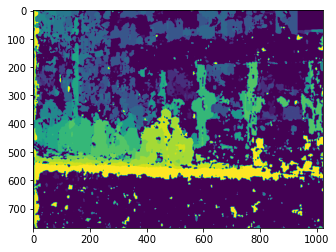

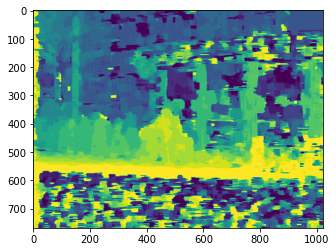

In [15]:
if testing: #plotting
    [disparity, disparity_dyn_prog] = stereo_vision('2')
    plot2 = plt.figure(6)
    plt.imshow(disparity, vmin=0, vmax=15)
    plot3 = plt.figure(7)
    plt.imshow(disparity_dyn_prog, vmin=0, vmax=15)